# Análisis sobre el impacto del bitcoin en la macroeconomía de El Salvador

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Tratamiento de datos

### 1.1 Deuda pública de El Salvador

In [17]:
ruta = "Datos_bitcoin/Deuda_SV/Deuda_Externa_Pública_Total.csv"
df = pd.read_csv(ruta, encoding='utf-8', sep=",",skiprows=4, skipfooter=2,engine="python") 
df = df.iloc[:7]
df[" "]=[
    'Total Deuda Externa Pública',
    'Total Sectores Público No Financiero',
    'Gobierno Central','Resto Del Gobierno Central',
    'Empresas Públicas No Financieras',
    'Total Sectores Públicos Financiero',
    'Banco Central De Reserva' ]
df.columns = ['Años', '2019', '2020', '2021', '2022']
df_DPE_concepto = df.set_index('Años').T
df_DPE_concepto["Gobierno Central"] = df_DPE_concepto["Gobierno Central"].values + df_DPE_concepto["Resto Del Gobierno Central"].values
df_DPE_concepto.drop(columns="Resto Del Gobierno Central", axis=1,inplace=True)
df_DPE_concepto


Años,Total Deuda Externa Pública,Total Sectores Público No Financiero,Gobierno Central,Empresas Públicas No Financieras,Total Sectores Públicos Financiero,Banco Central De Reserva
2019,9981.44,9636.70,9094.60,542.09,234.45,110.29
2020,11152.88,10745.16,10209.14,536.01,240.07,167.65
2021,11921.86,11454.13,10964.84,489.29,325.92,141.81
2022,11618.73,11123.60,10642.81,480.79,409.17,85.97


In [25]:
df_DPE = df_DPE_concepto["Total Deuda Externa Pública"]
df_DPE= df_DPE.reset_index()
df_DPE.columns =["Años","Total Deuda Externa Pública"]
df_DPE.set_index("Años", inplace=True)
df_DPE

,Total Deuda Externa Pública
Años,
2019,9981.44
2020,11152.88
2021,11921.86
2022,11618.73


#### 1.1.1 Diagrama lineal

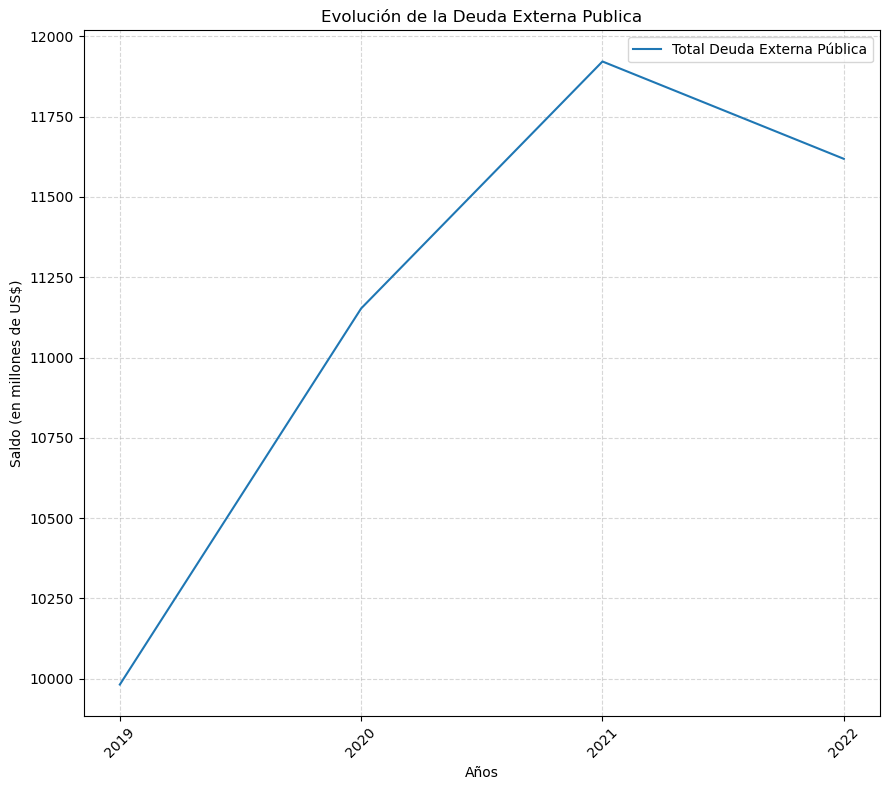

In [29]:
plt.figure(figsize=(9, 8))
for column in df_DPE.columns:
    plt.plot(df_DPE.index, df_DPE[column], label=column)

plt.title("Evolución de la Deuda Externa Publica")
plt.xlabel("Años")
plt.ylabel("Saldo (en millones de US$)")
plt.xticks(rotation=45)  
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()


plt.tight_layout()
plt.show()

El 7 de septiembre de 2021, El Salvador adoptó el Bitcoin como moneda legal. Antes de esto, la deuda externa pública del país venía subiendo. Pasó de 9,981.44 millones en 2019 a 11,152.88 millones en 2020, y alcanzó su nivel más alto en 2021 con 11,921.86 millones. Sin embargo, en 2022, la deuda bajó un poco, llegando a 11,618.73 millones

### 1.2 Índice de precios al consumidor (IPC)

In [29]:
ipc_file_path = "Datos_bitcoin/IPC_SV/Índice_de_Precios_al_Consumidor_(IPC).csv"

df_ipc = pd.read_csv(ipc_file_path, encoding='ISO-8859-1', sep=",", skiprows=4)
df_ipc = df_ipc.iloc[:-2]

data = {}
fechas = pd.date_range(start="2019-01-01", end="2022-12-01", freq="MS")
columnas = [
    "Índice general", 
    "Alimentos y bebidas no alcohólicas", 
    "Bebidas alcohólicas, tabaco", 
    "Prendas de vestir y calzado",
    "Alojamiento, agua, electricidad, gas y otros combustibles"    ,
    "Muebles, artículos para el hogar y para la conservación ordinaria del hogar",
    "Salud",
    "Transporte",
    "Comunicaciones",
    "Recreación y cultura",
    "Educación",
    "Restaurantes y hoteles",
    "Bienes y servicios diversos"
]

for i in range(0, len(df_ipc)):
    data[i] = df_ipc.iloc[i, 1:-1].values

df_ipc = pd.DataFrame(data)
df_ipc.columns = columnas
df_ipc.index = fechas
df_ipc.index.name = "Fecha"
df_ipc = df_ipc.astype(float)
#df_ipc.head()
df_ipc.describe()

,Índice general,Alimentos y bebidas no alcohólicas,"Bebidas alcohólicas, tabaco",Prendas de vestir y calzado,"Alojamiento, agua, electricidad, gas y otros combustibles","Muebles, artículos para el hogar y para la conservación ordinaria del hogar",Salud,Transporte,Comunicaciones,Recreación y cultura,Educación,Restaurantes y hoteles,Bienes y servicios diversos
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,116.158333,128.154792,154.890208,94.202917,136.774167,104.616042,102.697083,110.656667,83.287917,90.302083,114.297917,129.324167,111.962708
std,5.235353,8.538401,5.033957,2.633414,4.602943,6.017728,2.813095,5.500135,0.511031,3.654305,0.866656,6.473329,5.328848
min,111.560000,120.640000,146.840000,91.030000,128.610000,98.940000,99.270000,100.480000,82.270000,87.580000,113.270000,123.370000,107.130000
25%,112.167500,122.235000,151.492500,92.007500,132.385000,100.057500,100.067500,106.805000,83.030000,87.882500,113.957500,124.222500,107.532500
50%,112.940000,124.140000,154.605000,92.965000,136.450000,100.960000,101.970000,110.510000,83.120000,88.495000,114.260000,126.185000,110.090000
75%,119.242500,132.420000,157.710000,95.957500,141.245000,107.932500,105.100000,113.787500,83.325000,91.127500,114.272500,133.972500,114.140000
max,127.770000,148.240000,165.570000,99.850000,144.440000,116.570000,107.620000,122.510000,84.640000,98.520000,116.030000,144.470000,125.300000


#### 1.2.1 Diagrama lineal

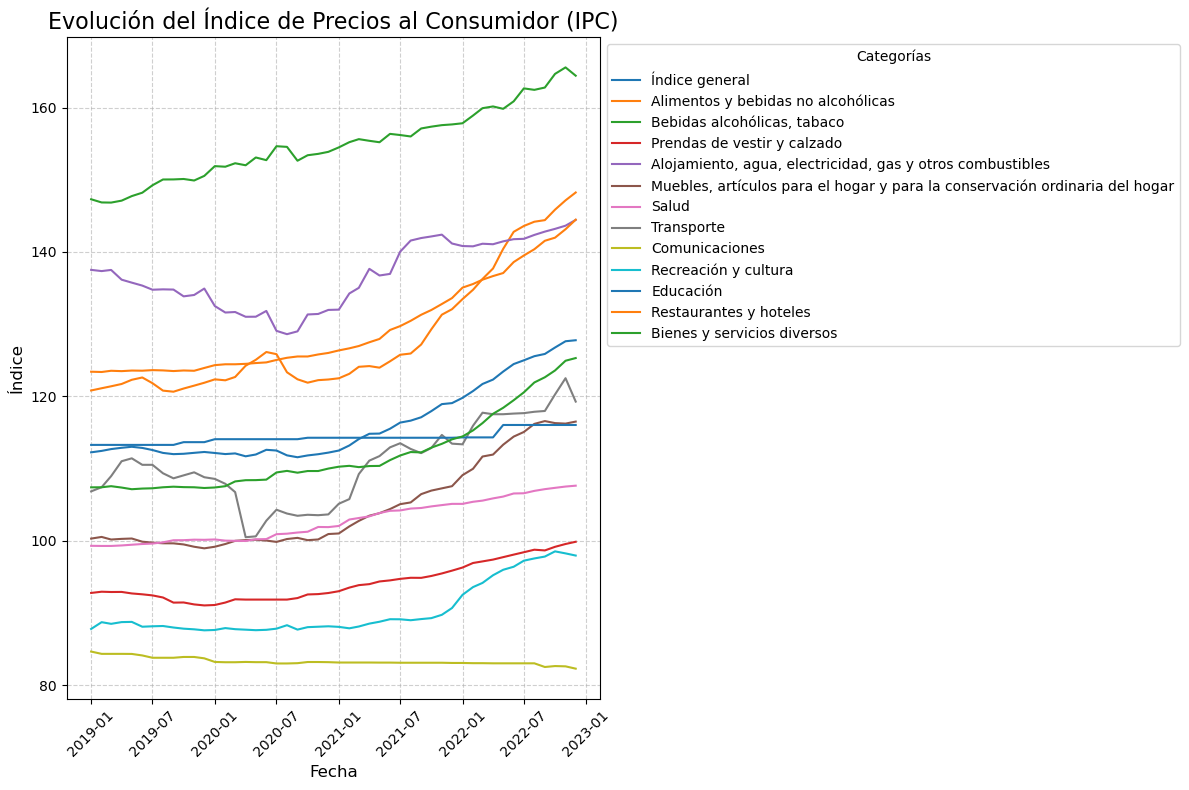

In [66]:
plt.figure(figsize=(12, 8))
for column in df_ipc.columns:
    plt.plot(df_ipc.index, df_ipc[column], label=column)

plt.title("Evolución del Índice de Precios al Consumidor (IPC)", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.xticks(rotation=45)
plt.ylabel("Índice", fontsize=12)
plt.legend(title="Categorías", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### 1.3 Producto interno bruto (PIB) de El Salvador

In [2]:
import pandas as pd

file_path = "Datos_bitcoin/PIB_SV/Producto_Interno_Bruto__Producción_Gasto_e_Ingreso_A_precios_corrientes.csv"

df = pd.read_csv(file_path, encoding='ISO-8859-1', sep=',', skiprows=4)
pib = pd.Series(df.columns[1:])

df_pib = pd.DataFrame(pib, columns=["PIB en millones"])
df_pib.index = [2019, 2020, 2021, 2022, 2023]
df_pib.index.name = "Año"
df_pib["PIB en millones"] = df_pib["PIB en millones"].astype(float)

df_pib_filtered = df_pib.loc[2019:2022]

print(df_pib_filtered)


      PIB en millones
Año                  
2019         26881.14
2020         24921.19
2021         29043.14
2022         31988.92


#### 1.3.1 Diagrama lineal

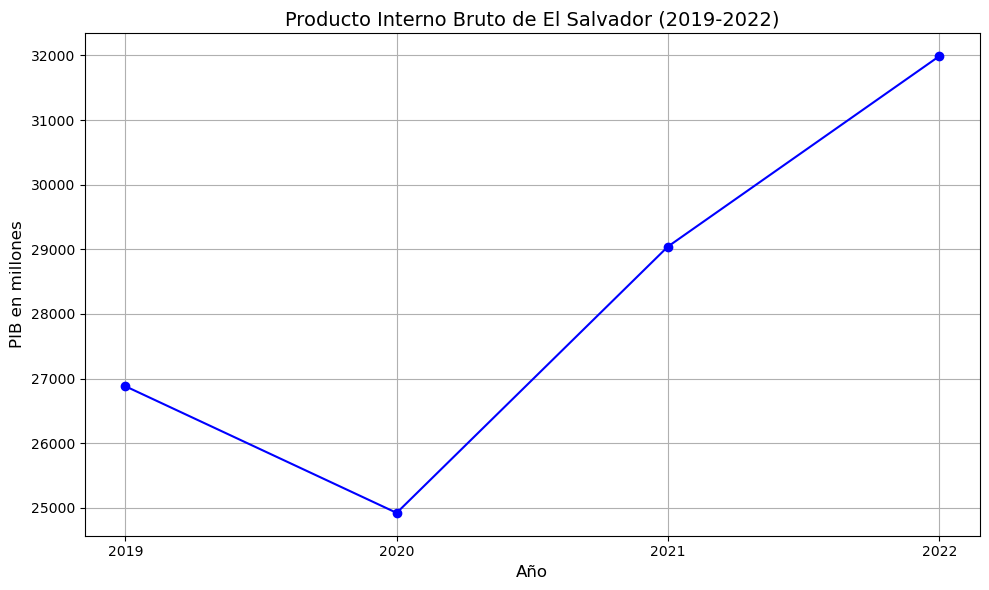

In [3]:
# Código para mostrar el diagrama lineal
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_pib_filtered.index, df_pib_filtered["PIB en millones"], marker='o', linestyle='-', color='b')
plt.title("Producto Interno Bruto de El Salvador (2019-2022)", fontsize=14)
plt.xlabel("Año", fontsize=12)
plt.ylabel("PIB en millones", fontsize=12)
plt.grid(True)
plt.xticks(df_pib_filtered.index, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()


### 1.4 Inversion extranjera

In [3]:
# Código para mostrar el dataframe de inversión extranjera
import pandas as pd

path_relative = "Datos_bitcoin/Inversion_SV/Posición_de_Inversión_Internacional_a_fin_de_período.csv"

df = pd.read_csv(path_relative, encoding='ISO-8859-1', skiprows=2, header=None)

headers = df.iloc[1, 1:].values  # Fechas
concepts = df.iloc[2:, 0]  # Conceptos (e.g., Posición Neta, Activos)

concepts = concepts.str.replace('Ã³', 'ó').str.replace('Ã±', 'ñ').str.replace('Ã®', 'í')

notes_keywords = ["Notas", "Con el fin de mejorar", "eurobonos emitidos"]
rows_to_keep = ~concepts.str.contains('|'.join(notes_keywords), na=False)

filtered_concepts = concepts[rows_to_keep].reset_index(drop=True)
filtered_data = df.iloc[2:, 1:].loc[rows_to_keep].reset_index(drop=True)

df_data = pd.DataFrame(data=filtered_data.values, index=filtered_concepts, columns=headers)

filtered_columns = [col for col in df_data.columns if str(col).startswith(("2019", "2020", "2021", "2022"))]
df_filtered = df_data[filtered_columns].copy()

df_filtered = df_filtered.apply(pd.to_numeric, errors='coerce')

df_transformed = df_filtered.T
df_transformed.index.name = 'Fecha'
df_transformed.columns.name = 'Concepto'

df_transformed = df_transformed.dropna(how='all')

print(df_transformed)


Concepto   Posición de Inversión Internacional Neta   Activos   Pasivos
Fecha                                                                  
2019-01                                   -16948.47   9945.76  26894.23
2019-02                                   -17321.75  10176.15  27497.90
2019-03                                   -16998.44  11505.66  28504.10
2019-04                                   -17457.13  10895.98  28353.11
2020-01                                   -14330.71  12538.06  26868.77
2020-02                                   -14949.92  12739.54  27689.47
2020-03                                   -14754.92  13439.89  28194.81
2020-04                                   -15131.28  13803.11  28934.39
2021-01                                   -15707.86  13659.08  29366.93
2021-02                                   -15552.50  14108.03  29660.54
2021-03                                   -14974.97  14668.86  29643.83
2021-04                                   -14634.09  14886.07  2

#### 1.4.1 Diagrama lineal

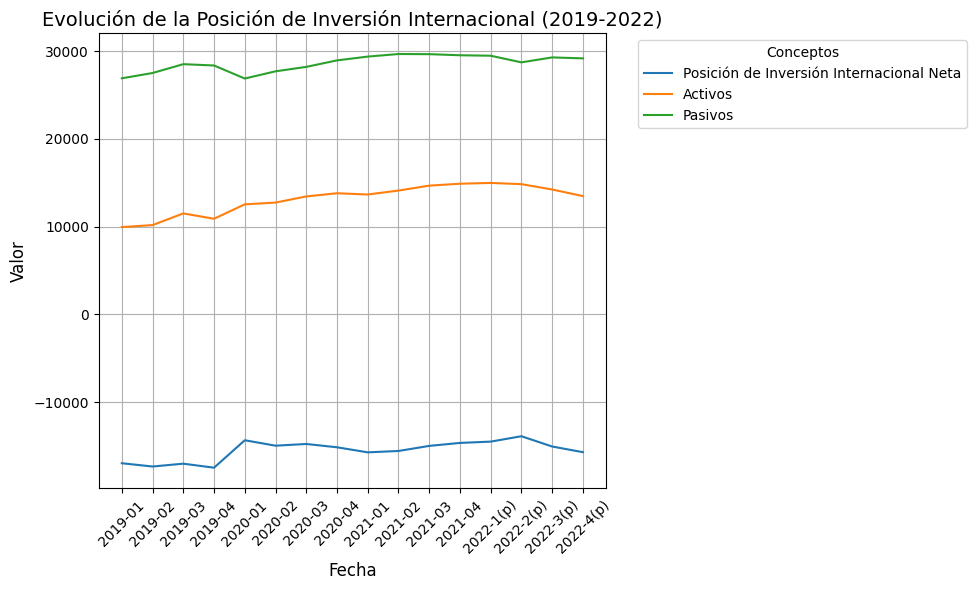

In [39]:
# Código para mostrar el diagrama lineal de la inversion extranjera
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for column in df_transformed.columns:
    plt.plot(df_transformed.index, df_transformed[column], label=column)

plt.title('Evolución de la Posición de Inversión Internacional (2019-2022)', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.legend(title='Conceptos', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()


### 1.5 Precio histórico del Bitcoin

In [92]:
import re

btc_file_path = "Datos_bitcoin/btc history/Bitcoin history.csv"
df_btc = pd.read_csv(btc_file_path, encoding='ISO-8859-1', sep=",")

df_btc.rename(columns={'ï»¿"Date"': 'Date'}, inplace=True)
df_btc.set_index("Date", inplace=True)

df_btc.index = pd.to_datetime(df_btc.index, format="%b %d, %Y")
df_btc = df_btc.sort_index()
df_btc = df_btc.loc['2019-01-01':'2022-12-31']

df_btc = df_btc.map(lambda x: re.sub(r"[,%]", "", x) if isinstance(x, str) else x)
df_btc = df_btc.astype({"Price": float, "Open": float, "High": float, "Low": float, "Change %": float})
df_btc



,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-01-01,3809.4,3709.5,3814.3,3664.4,469.11K,2.69
2019-01-02,3873.8,3809.7,3894.8,3768.1,554.47K,1.69
2019-01-03,3780.1,3874.1,3875.8,3753.0,450.32K,-2.42
2019-01-04,3802.7,3780.5,3823.9,3720.0,488.70K,0.60
2019-01-05,3785.4,3802.8,3846.7,3769.0,468.45K,-0.46
...,...,...,...,...,...,...
2022-12-27,16706.1,16918.2,16964.0,16610.1,192.18K,-1.25
2022-12-28,16546.2,16705.9,16781.1,16474.2,217.96K,-0.96
2022-12-29,16636.4,16546.2,16659.1,16496.6,181.47K,0.55


#### 1.5.1 Diagrama lineal

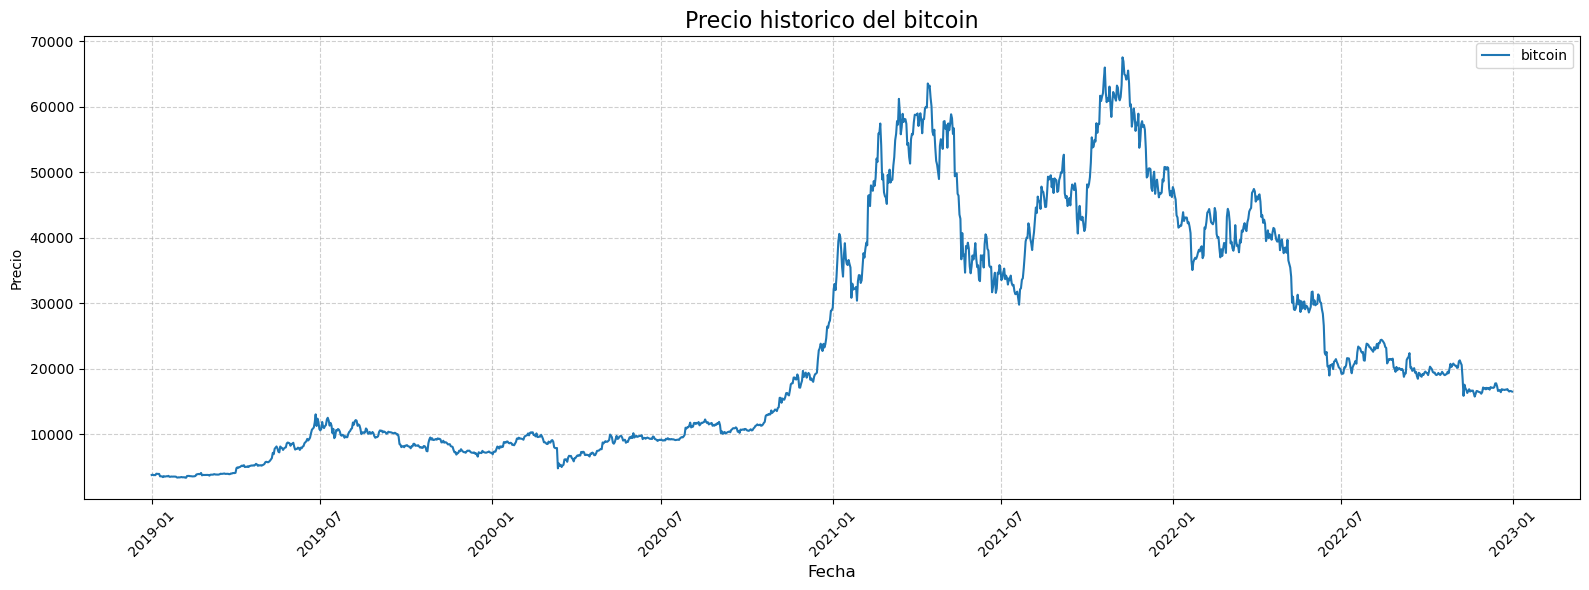

In [94]:
plt.figure(figsize=(16, 6))
plt.plot(df_btc.index, df_btc["Price"], label="bitcoin")

plt.title("Precio historico del bitcoin", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.xticks(rotation=45)
plt.ylabel("Precio")
plt.legend()

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### 1.6 Reserva nacional

In [4]:
import pandas as pd
btc_file_path = "Datos_bitcoin/Reservas_BCR/Reservas_Internacionales_Netas_BCR.csv"
csv = pd.read_csv(btc_file_path, sep=",")
df_reserva = pd.DataFrame(csv)

df_reserva.drop(index=[0,1,6], axis=0, inplace=True)
df_reserva.columns = df_reserva.iloc[0]
df_reserva.drop(index=2, axis=0, inplace=True)
df_reserva = df_reserva.T
df_reserva.columns = df_reserva.iloc[0]
df_reserva.drop(index=['Concepto'],inplace=True)
df_reserva.to_csv('Datos_bitcoin/Reservas_BCR/reservasinternacionales.csv')

#### 1.6.1 Diagrama lineal

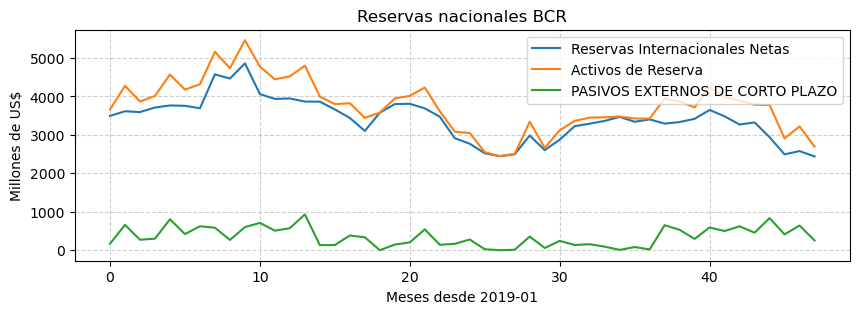

In [5]:
import matplotlib.pyplot as plt
df_reserva2 = pd.read_csv('Datos_bitcoin/Reservas_BCR/reservasinternacionales.csv') #dataframe ya procesado

df_reserva2.plot(kind='line',figsize=(10, 3),fontsize=10)
plt.title('Reservas nacionales BCR')
plt.xlabel('Meses desde 2019-01'), plt.ylabel('Millones de US$')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

A pesar de la adopción del bitcoin como activo de reserva, los datos reflejados por el BCR muetran que las la mayoría de indicadores de reservas nacionales han decaido desde la adopción del bitcoin, por medio de la documentación del BCR acerca de estos datos no se puede precisar si el bitcoin se toma en cuenta en estos indicadores, pero se puede suponer que el indicador relacionado con las reservas en bitcoin sería 'PASIVOS EXTERNOS DE CORTO PLAZO', este indicador tuvo un aumento del +52% entre el primer mes del 2019 y el ultimo mes de 2022.

## 2. Análisis de datos